In [2]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from scipy import stats
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import sys
import os

sys.path.append('../')
from utils.training import *
from utils.losses import *

np.random.seed(666)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_mults = mc['sim_mults']
sim_lhas = mc['sim_lhas']
sim_widths = mc['sim_widths']
sim_ang2s = mc['sim_ang2s']
sim_tau2s = mc['sim_tau2s']
sim_sdms = mc['sim_sdms']
sim_zgs = mc['sim_zgs']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [17]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [18]:
n, d = dat.shape

# Load Flows

In [9]:
#dat_target = make_target(d)
#dat_target = make_target(d, num_hidden = 16)
#dat_target = make_target(d, num_ffjords = 8)
dat_target = make_target(d) #dat10
sim_target = make_target(d) #sim5

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

2023-11-06 11:54:42.566080: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 11:54:43.201254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17075 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


In [10]:
#dat_ckpt.restore('dat7/ckpt-392')
#dat_ckpt.restore('dat8/ckpt-469')
#dat_ckpt.restore('dat9/ckpt-392')
#dat_ckpt.restore('dat12/ckpt-488')
#sim_ckpt.restore('sim4/ckpt-379')
dat_ckpt.restore('dat/full/ckpt-46267')
sim_ckpt.restore('sim/full/ckpt-34813')
# 43248 for dat
# 35865 for sim
#dat_ckpt.restore('dat/best/ckpt-451')
#sim_ckpt.restore('sim/2/ckpt-327')

In [11]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

# Histograms

In [12]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], 51)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Data

In [157]:
with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(dat_target.log_prob(dat[0:1000, :]))
    
loss = round(loss.numpy(), 2)
loss

12.57

In [13]:
experiment = 'dat/full'

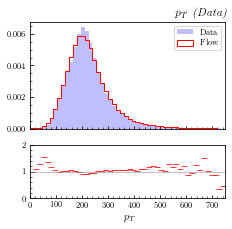

In [14]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT_data.png'.format(experiment)
          )

/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


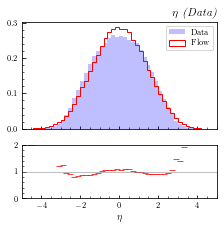

In [15]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta_data.png'.format(experiment)
          )

/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


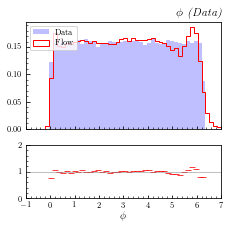

In [16]:
ratio_hist(dat[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$\phi$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\phi$ (Data)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/{}/phi_data.png'.format(experiment)
          )

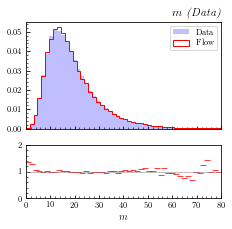

In [17]:
ratio_hist(dat[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m_data.png'.format(experiment)
          )

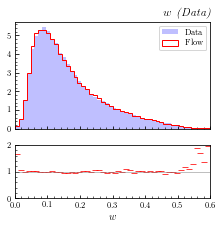

In [18]:
ratio_hist(dat[:, 4], dat_smp[:, 4], 
           labels = ['Data', 'Flow', r'$w$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $w$ (Data)',
           x_lim = (0, 0.6),
           filename = '../plots/zenodo/flows/{}/w_data.png'.format(experiment)
          )

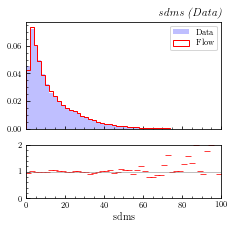

In [19]:
ratio_hist(dat[:, 5], dat_smp[:, 5], 
           labels = ['Data', 'Flow', r'sdms'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it sdms (Data)',
           x_lim = (0, 100),
           filename = '../plots/zenodo/flows/{}/sdms_data.png'.format(experiment)
          )

## MC

In [165]:
with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(sim_target.log_prob(sim[0:1000, :]))
    
loss = round(loss.numpy(), 2)
loss

12.45

In [20]:
experiment = 'sim/full'

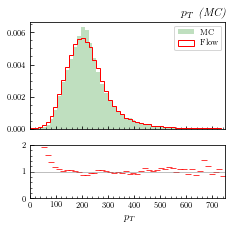

In [21]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


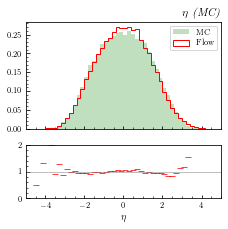

In [22]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


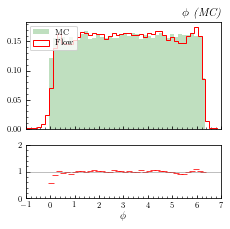

In [23]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

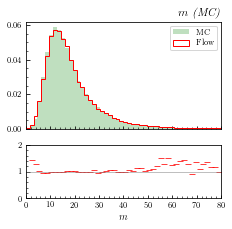

In [24]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

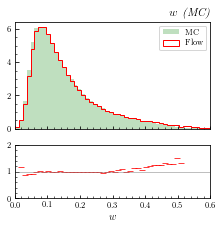

In [25]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_22059/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


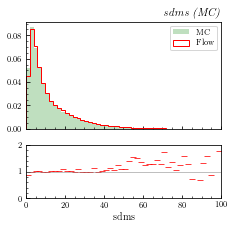

In [26]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

# Classification

## MC

In [27]:
X_bkgd = sim_smp
X_sgnl = sim

In [28]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [29]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [30]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

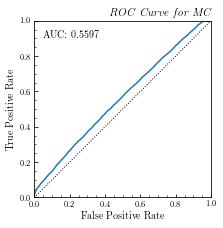

In [32]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
#plt.text(0.04, 0.85, 'Loss: {}'.format(loss))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/{}/mc_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

## Data

In [33]:
X_bkgd = dat_smp
X_sgnl = dat

In [34]:
experiment = 'dat/full'

In [35]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [36]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [37]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

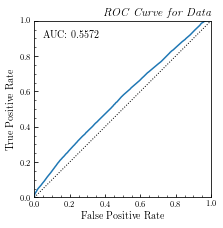

In [38]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Data', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/{}/data_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

# Checkpoint Checks

In [6]:
def calculate_auc(fake, real):
    np.random.seed(666)
    n, d = fake.shape
    y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
    X = np.zeros_like(fake)
    X[y == 0] = real[y == 0]
    X[y == 1] = fake[y == 1]

    # Take 70% of data to be training data.
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size = 0.7)
    ab_clf = AdaBoostClassifier()
    ab_clf.fit(X_trn, y_trn)
    
    y_hat = ab_clf.predict_proba(X_tst)[:, 1]
    auc = metrics.roc_auc_score(y_tst, y_hat)
    return auc

## Dat Best

In [ ]:
num_ckpts = 534
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    dat_target = make_target(d)
    dat_ckpt = tf.train.Checkpoint(dat_target)
    dat_ckpt.restore('dat/best/ckpt-{}'.format(i))
    
    dat_smp = dat_target.sample(n)
    aucs[i - 1] = calculate_auc(dat_smp, dat)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

In [ ]:
plt.plot(ns, aucs)
plt.ylim(0.51, 0.57)

## Sim 1

In [ ]:
num_ckpts = 77
num_sim = 1
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 2

In [ ]:
num_ckpts = 392
num_sim = 2
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 3

In [ ]:
num_ckpts = 392
num_sim = 3
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 4

In [ ]:
num_ckpts = 39
num_sim = 4
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 5

In [ ]:
num_ckpts = 196
num_sim = 5
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 6

In [ ]:
num_ckpts = 196
num_sim = 6
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 7

In [ ]:
num_ckpts = 47
num_sim = 7
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 8

In [ ]:
num_ckpts = 99
num_sim = 8
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 9

In [ ]:
num_ckpts = 99
num_sim = 9
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

In [ ]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_w = mc['sim_widths']
sim_sdms = mc['sim_sdms']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m, sim_w, sim_sdms]).T

In [ ]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]
dat_w = dat['sim_widths']
dat_sdms = dat['sim_sdms']

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m, dat_w, dat_sdms]).T

In [ ]:
n, d = dat.shape

# 6 Vectors

In [6]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_w = mc['sim_widths']
sim_sdms = mc['sim_sdms']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m, sim_w, sim_sdms]).T

In [7]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]
dat_w = dat['sim_widths']
dat_sdms = dat['sim_sdms']

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m, dat_w, dat_sdms]).T

In [8]:
n, d = dat.shape

## Sim Full

In [ ]:
num_ckpts = 10500
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/full/ckpt-{}'.format(i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    if i % 100 == 0:
        print(i, '\t', round(aucs[i - 1], 4))

100 	 1.0
200 	 1.0
300 	 0.9998
400 	 0.9977
500 	 0.9944
600 	 0.9841
700 	 0.9517
800 	 0.9167
900 	 0.8855
1000 	 0.8434
1100 	 0.8013
1200 	 0.7726
1300 	 0.7449
1400 	 0.7277
1500 	 0.7137
1600 	 0.7117
1700 	 0.6992


In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

In [ ]:
np.save('sim_aucs.npy', aucs)

## Dat Full

In [ ]:
num_ckpts = 14500
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    dat_target = make_target(d)
    dat_ckpt = tf.train.Checkpoint(dat_target)
    dat_ckpt.restore('dat/full/ckpt-{}'.format(i))
    
    dat_smp = dat_target.sample(n)
    aucs[i - 1] = calculate_auc(dat_smp, dat)
    if i % 100 == 0:
        print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

In [ ]:
np.save('dat_aucs.npy', aucs)

## Sim Full 2

In [ ]:
num_ckpts = 54
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/full_2/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

In [ ]:
np.save('sim_aucs_2.npy', aucs)